# Autoencoder 

**Creating an AE that can learn an information rich spectral profiles embeddings to reconstruct the image/spetrum**

In [1]:
from pyimzml.ImzMLParser import ImzMLParser

p = ImzMLParser('../HIV.imzml')
my_spectra = []
for idx, (x,y,z) in enumerate(p.coordinates):
    mzs, intensities = p.getspectrum(idx)
    my_spectra.append([mzs, intensities, (x, y, z)])

/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:80: UserWarning: Unrecognized accession in <cvParam>:  (name: "").
  warn('Unrecognized accession in <cvParam>: %s (name: "%s").' % (accession, raw_name))
/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/vmuser/anaconda3/lib/python3.12/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


## Autoencoder Architecture for Mass Spectrometry Data

This is the implementation of a baseline **Autoencoder**. The autoencoder learns to encode spectral profiles into a lower-dimensional latent space representation, then reconstructs the original spectra from these compressed embeddings.

### Key Components:

#### 1. **Architecture Design**
- **Encoder**: Compresses spectral data from ~1400 peaks → 512 → 256 → 64 latent dimensions
- **Decoder**: Reconstructs from 64 latent dimensions → 256 → 512 → 1500 peaks
- **Activation Functions**: ReLU for hidden layers, linear output for intensity reconstruction





In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model


class SpectrumAutoencoder(Model):
    def __init__(self, latent_dim, n_peaks):
        super(SpectrumAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.n_peaks = n_peaks
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(n_peaks, activation='linear'),  
        ])

    def call(self, intensities):
        encoded = self.encoder(intensities)
        decoded_intensities = self.decoder(encoded)
        return decoded_intensities


#### 2. **Data Preprocessing**


- **Interpolation**: All spectra are resampled to a common m/z grid (1400 points from 100 to 1500 - see data analysis for range of mz) using linear interpolation 
- **Normalization**: Intensities are scaled to [0,1] range for stable training
- **Consistent Format**: Handles variable-length spectra 


In [ ]:
# Data preprocessing - convert all spectra to same length
from scipy.interpolate import interp1d

def preprocess_spectra(spectra_list, target_length=10000):
    processed_intensities = []
    all_mzs = []
    
    # Collect all mz values to find common range
    for spectrum in spectra_list:
        mzs, intensities, _ = spectrum
        all_mzs.extend(mzs)
    
    # Create common mz grid
    min_mz, max_mz = min(all_mzs), max(all_mzs)
    common_mzs = np.linspace(min_mz, max_mz, target_length)
    
 
    for spectrum in spectra_list:
        mzs, intensities, _ = spectrum
        # interpolator is a topic of discussion
        interpolator = interp1d(mzs, intensities, kind='linear', 
                    bounds_error=False, fill_value=0)
        
        interpolated_intensities = interpolator(common_mzs)
        processed_intensities.append(interpolated_intensities)
    

    X = np.array(processed_intensities)    
    #  normalization to [0, 1] range 
    X_min = X.min()
    X_max = X.max()
    X = (X - X_min) / (X_max - X_min)
    
    return X, common_mzs

# Preprocess the data
print(f"Total spectra: {len(my_spectra)}")
X_processed, common_mzs = preprocess_spectra(my_spectra)
print(f"Processed data shape: {X_processed.shape}")
print(f"Data range: [{X_processed.min():.4f}, {X_processed.max():.4f}]")

Total spectra: 56678


#### 3. **Training Strategy**
- **Loss Function**: Mean Squared Error (MSE) for reconstruction fidelity
- **Optimization**: Adam optimizer
- **Regularization**: Early stopping to prevent overfitting
- **Validation**: 80/20 train-test split for performance evaluation


In [ ]:
# Split data into train and test sets
X_train, X_test = train_test_split(X_processed, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

latent_dim = 64  
input_dim = X_train.shape[1]  

autoencoder = SpectrumAutoencoder(latent_dim=latent_dim, n_peaks=input_dim)

# Compile the model
autoencoder.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for reconstruction
    metrics=['mae']  # Mean Absolute Error as additional metric
)

print(f"Autoencoder created with latent_dim={latent_dim}, input_dim={input_dim}")

Training set shape: (45342, 3000)
Test set shape: (11336, 3000)
Autoencoder created with latent_dim=64, input_dim=3000


2025-08-09 19:36:26.812421: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Training the autoencoder
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Check data before training
print(f"Training data stats:")
print(f"  Shape: {X_train.shape}")
print(f"  Min: {X_train.min():.6f}, Max: {X_train.max():.6f}")
print(f"  Mean: {X_train.mean():.6f}, Std: {X_train.std():.6f}")


print("Starting training...")
history = autoencoder.fit(
    X_train, X_train,  
    epochs=10,  
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping],
    verbose=1
)

print("Training completed!")

Training data stats:
  Shape: (45342, 3000)
  Min: 0.000000, Max: 1.000000
  Mean: 0.001161, Std: 0.005549
Starting training...
Epoch 1/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - loss: 4.7235e-06 - mae: 6.8963e-04 - val_loss: 1.8388e-06 - val_mae: 5.5447e-04
Epoch 2/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - loss: 1.5605e-06 - mae: 5.1096e-04 - val_loss: 1.3882e-06 - val_mae: 4.7633e-04
Epoch 3/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 1.2730e-06 - mae: 4.5707e-04 - val_loss: 1.2196e-06 - val_mae: 4.4013e-04
Epoch 4/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 1.1679e-06 - mae: 4.3008e-04 - val_loss: 1.1520e-06 - val_mae: 4.3224e-04
Epoch 5/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 1.1077e-06 - mae: 4.2831e-04 - val_loss: 1.1373e-06 - val_mae: 4.2513e-04
Epoch 6/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - loss: 1.0493e-06 - mae: 4.1875e-04 - val_loss: 1.0417e-06 - val_mae: 4.1608e-04
Epoch 7/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 45

#### 5. **Evaluation Metrics**
- **Reconstruction Error**: MSE and MAE between original and reconstructed spectra
- **Visual Assessment**: Direct comparison plots of original vs. reconstructed profiles

Test Loss (MSE): 0.000001
Test MAE: 0.000360


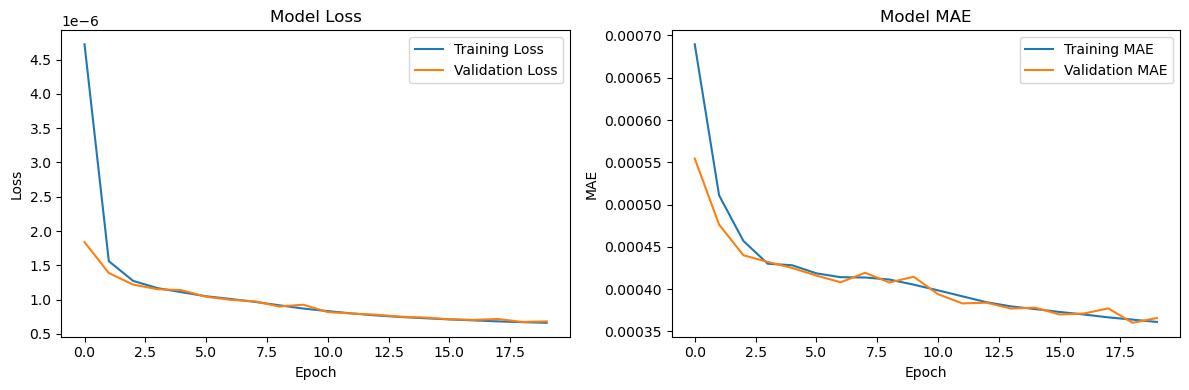

In [ ]:
# Evaluate the model
test_loss, test_mae = autoencoder.evaluate(X_test, X_test, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

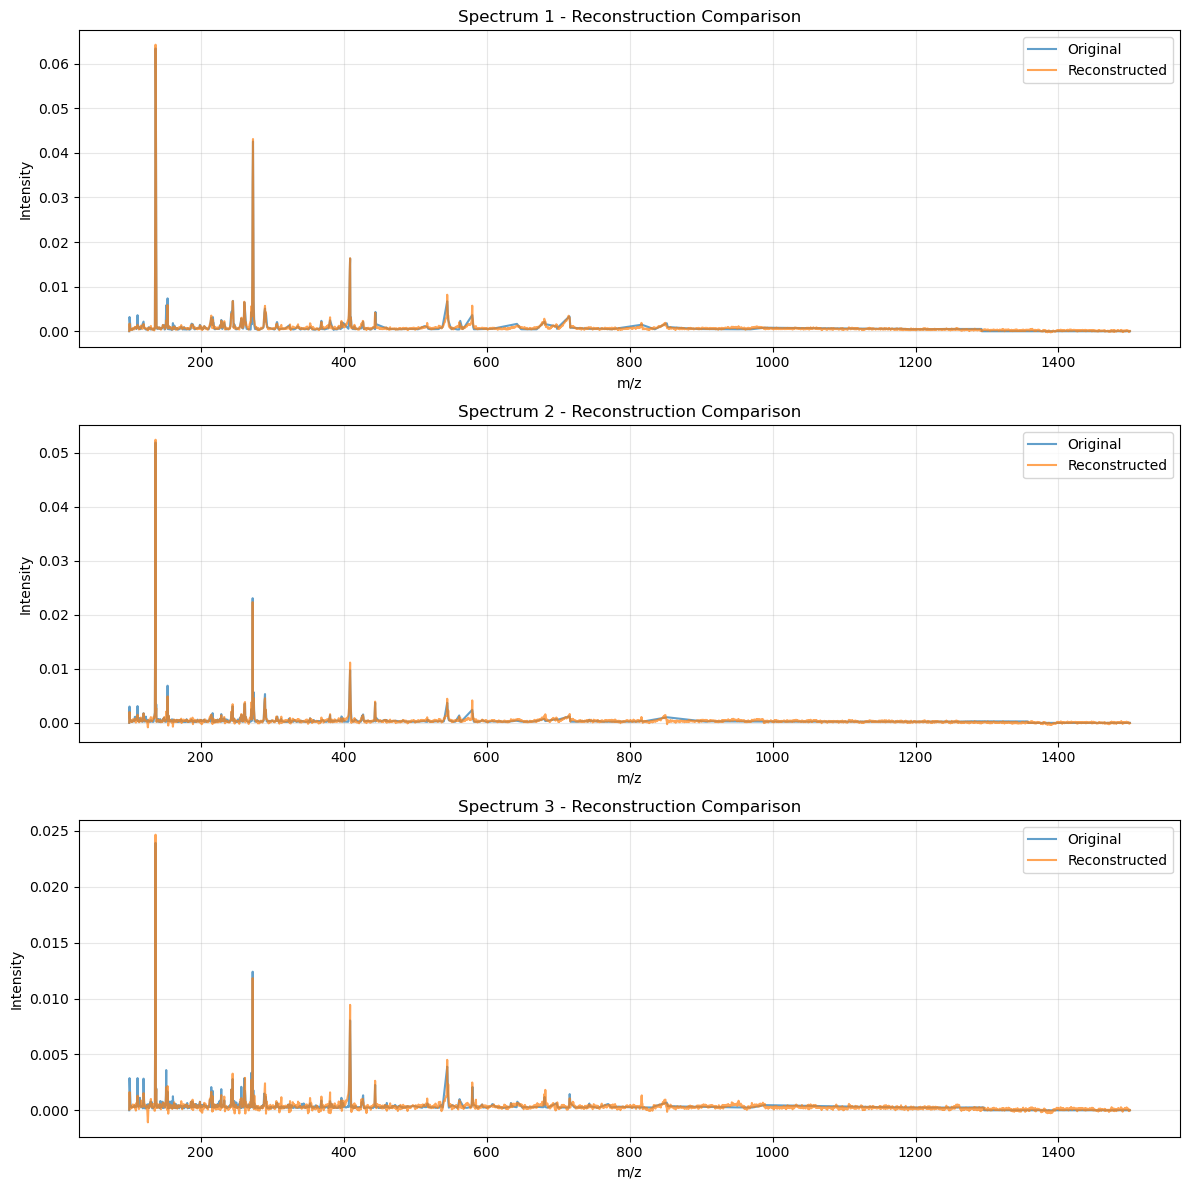

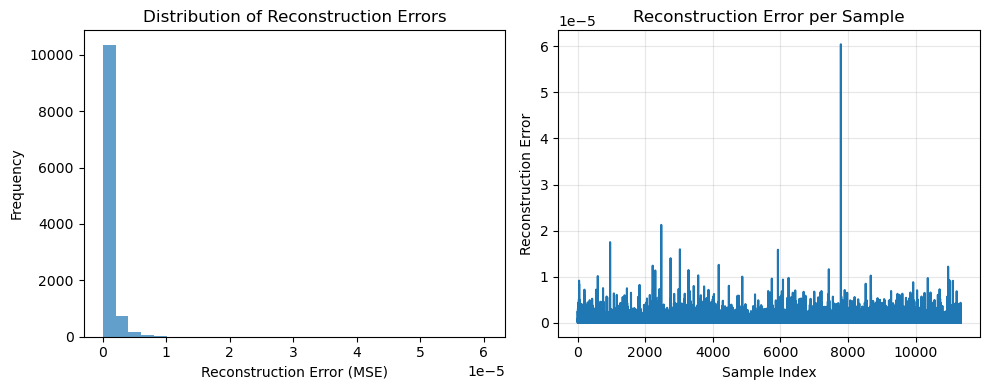

Mean reconstruction error: 0.000001


In [ ]:
# Plot original (after preprocessing) vs reconstructed spectra
import random
def plot_reconstruction_comparison(autoencoder, X_test, common_mzs):
    # Plot the 3 random samples vs thier reconstruction
    
    spectrum1, spectrum2, spectrum3 = random.sample(range(0,len(X_test)),3)
    spectra_indexes = [spectrum1,spectrum2,spectrum3]
    reconstructed = autoencoder(np.array([X_test[spectrum1],X_test[spectrum2],X_test[spectrum3]]))
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 4*3))
    
    for i in range(3):
        axes[i].plot(common_mzs, X_test[spectra_indexes[i]], label='Original', alpha=0.7)
        axes[i].plot(common_mzs, reconstructed[i], label='Reconstructed', alpha=0.7)
        axes[i].set_xlabel('m/z')
        axes[i].set_ylabel('Intensity')
        axes[i].set_title(f'Spectrum {i+1} - Reconstruction Comparison')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


plot_reconstruction_comparison(autoencoder, X_test, common_mzs)

reconstructed_test = autoencoder(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructed_test), axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(reconstruction_errors, bins=30, alpha=0.7)
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')

plt.subplot(1, 2, 2)
plt.plot(reconstruction_errors)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error per Sample')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean reconstruction error: {np.mean(reconstruction_errors):.6f}")

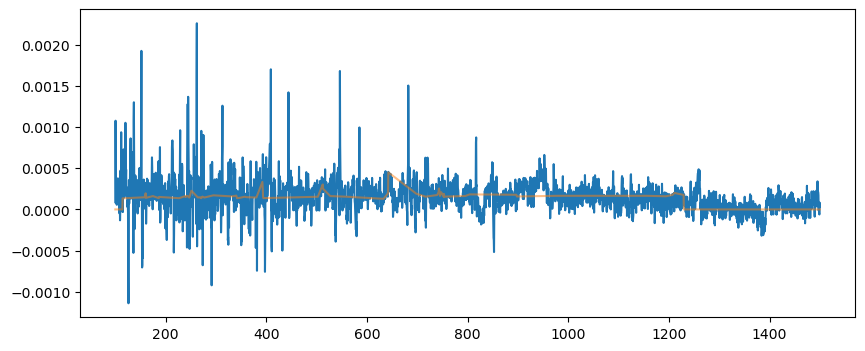

72

In [ ]:
# plot various recreations of spectra vs each other
# plt.plot(common_mzs,X_processed[2])
# plt.show()

# print(np.array(X_processed[0]))
r = autoencoder(np.array([X_processed[0]]))
plt.figure(figsize=(10,4))
plt.plot(common_mzs,r[0])
plt.plot(common_mzs,X_processed[0],alpha=0.5)

plt.show()

# It seems to be true that there are some spectra that are not reconstrcted well by the AE , e.g index 0,1,2
# My hypothesis is that such points have a low amount of the total number of mz actually recorded - high interpolation
len(my_spectra[20][0])


In [ ]:
# I want export an array of the interopolated OG data and the reconstructed data.
# print(X_processed.shape)

reconstructions = np.array(autoencoder(X_processed))

with open("HIV_Common_mzs.npy",'wb') as file:
    np.save(file,common_mzs)

with open("HIV_OG_Normalized.npy",'wb') as file:
    np.save(file,X_processed)

with open("HIV_Recon_Normalized.npy",'wb') as file:
    np.save(file,reconstructions)
    

2025-08-09 19:54:42.010254: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1360272000 exceeds 10% of free system memory.


In [ ]:
print(np.array(reconstructions))


[[ 8.76466875e-05  1.07757933e-03  5.01631352e-04 ... -6.13108277e-05
   8.27183831e-05  2.89187301e-05]
 [ 7.34334390e-05  1.05217635e-03  5.09822974e-04 ... -5.47501841e-05
   7.81347626e-05  2.30090227e-05]
 [ 8.30154822e-05  1.06908579e-03  5.09292120e-04 ... -5.63989743e-05
   8.16897373e-05  2.16378830e-05]
 ...
 [-8.71663869e-05 -7.53458240e-04  9.07308422e-05 ...  1.18012947e-04
   1.27784500e-04 -4.05269675e-05]
 [ 2.02281444e-05  6.92359405e-04  8.84474255e-04 ... -1.02948456e-04
   2.72980018e-04  1.35541428e-04]
 [ 1.17998854e-04 -1.63324503e-03  3.29594128e-04 ...  4.67131031e-05
   4.56663838e-04  1.43195502e-04]]


In [ ]:
count =0
indexes = []
for index in range(len(my_spectra)):
    if len(my_spectra[index][0]) < 250:
        count+=1
        indexes.append(index)
print(count)
print(len(my_spectra[indexes[3968]][0])) 
print(indexes[3968])       

3970
231
56613


In [ ]:
common_mzs

array([ 100.00035858,  100.46717451,  100.93399044, ..., 1499.04769139,
       1499.51450732, 1499.98132324])